# Chapter 5 - Cross Vaildation

- [Load dataset](#Load-dataset)
- [Cross-Validation](#5.1-Cross-Validation)

In [148]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
plt.style.use('seaborn-white')

### Load dataset

Dataset available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [149]:
df1 = pd.read_csv('https://www.palmetto.clemson.edu/dsci/datasets/isl/Auto.csv', na_values='?').dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


### Polynomial Regression

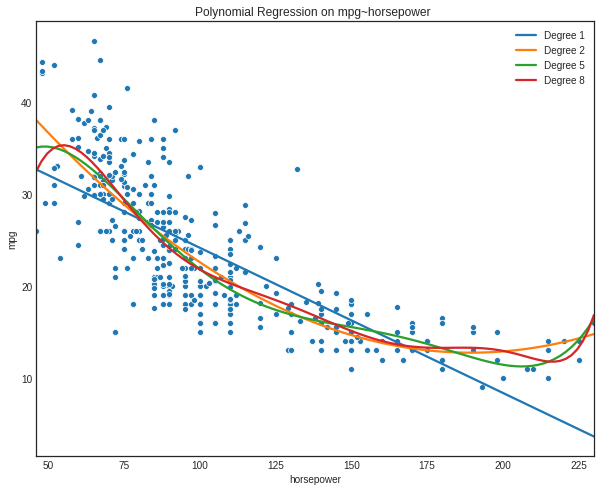

In [150]:
df = pd.read_csv('https://www.palmetto.clemson.edu/dsci/datasets/isl/Auto.csv', na_values='?').dropna()
fig, ax = plt.subplots(figsize=(10, 8))
_ = sns.scatterplot(x='horsepower', y='mpg', data=df)
for deg in [1, 2, 5, 8]:
    sns.regplot(df.horsepower, df.mpg, ci=None, label='Degree {}'.format(deg), order=deg, scatter=False)
plt.title('Polynomial Regression on mpg~horsepower ')
plt.legend()
plt.show()

### Overfitting

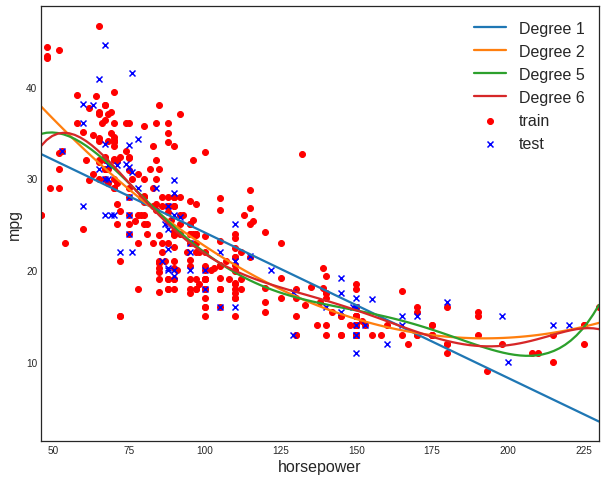

In [151]:
df = pd.read_csv('https://www.palmetto.clemson.edu/dsci/datasets/isl/Auto.csv', na_values='?').dropna()

# df = df.sample(n=80,  random_state=0)
X_train, X_test, y_train, y_test = train_test_split(df['horsepower'], df['mpg'], test_size=0.2, random_state=0)

fig, ax = plt.subplots(figsize=(10, 8))
_ = ax.scatter(X_train, y_train, marker='o', color='r', label='train')
_ = ax.scatter(X_test, y_test, marker='x', color='b', label='test')
_ = ax.set_xlabel('horsepower', fontsize=16)
_ = ax.set_ylabel('mpg', fontsize=16)

for deg in [1, 2, 5, 6]:
    sns.regplot(X_train, y_train, ci=None, label='Degree {}'.format(deg), order=deg, scatter=False, ax=ax)

_ = ax.legend(fontsize=16)

In [152]:
from collections  import defaultdict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

model_perf = defaultdict(dict)

def compute_model_perf(model_name, tag, y_true, y_pred):
    model_perf[model_name]['{}.explained_variance'.format(tag)] = explained_variance_score(y_true, y_pred)
    model_perf[model_name]['{}.RSME'.format(tag)] = mean_squared_error(y_true, y_pred, squared=False)
    model_perf[model_name]['{}.R2'.format(tag)] = r2_score(y_true, y_pred)
    model_perf[model_name]['{}.RelativeError'.format(tag)] = mean_squared_error(y_true/y_true, y_pred/y_true, squared=False)

df = pd.read_csv('https://www.palmetto.clemson.edu/dsci/datasets/isl/Auto.csv', na_values='?').dropna()
X_train, X_test, y_train, y_test = train_test_split(df['horsepower'], df['mpg'], test_size=0.3, random_state=2020)

for deg in range(1, 16):
    model = make_pipeline(PolynomialFeatures(deg), LinearRegression())
    model.fit(X_train[:, np.newaxis], y_train)

    model_name = "poly-{}".format(deg)
    y_train_pred = model.predict(X_train[:, np.newaxis])
    y_test_pred = model.predict(X_test[:, np.newaxis])
    compute_model_perf(model_name, 'Train', y_train, y_train_pred)
    compute_model_perf(model_name, 'Test', y_test, y_test_pred)
df_perf = pd.DataFrame(model_perf).T
df_perf[['Train.RSME', 'Test.RSME']]

,Train.RSME,Test.RSME
poly-1,4.839304,5.041419
poly-2,4.293526,4.511749
poly-3,4.292696,4.528224
poly-4,4.234097,4.700435
poly-5,4.149894,4.719823
poly-6,4.133391,4.685837
poly-7,4.154881,4.706380
poly-8,4.184178,4.703500
poly-9,4.204877,4.659320
poly-10,4.203132,4.604809


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


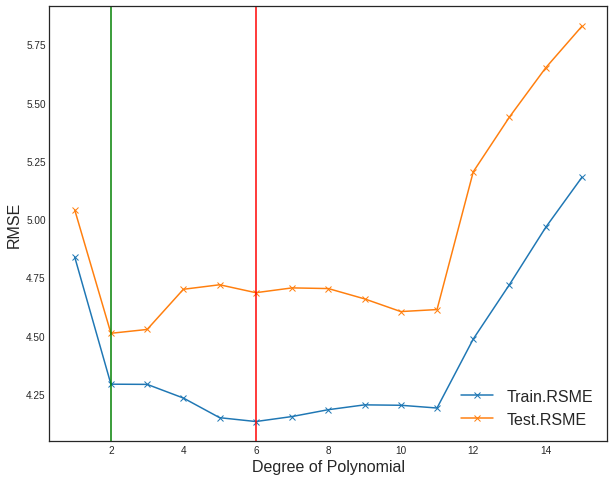

In [153]:
fig, ax = plt.subplots(figsize=(10, 8))
rmses = df_perf[['Train.RSME', 'Test.RSME']]
idx = np.arange(1, rmses.shape[0]+1)
print(idx)
rmses = rmses.set_index(idx)
rmses.plot(ax=ax, marker='x')
_ = ax.set_xlabel('Degree of Polynomial', fontsize=16)
_ = ax.set_ylabel('RMSE', fontsize=16)
plt.legend(fontsize=16)
best_train_deg = rmses['Train.RSME'].argmin()+1
best_test_deg = rmses['Test.RSME'].argmin()+1
_ = ax.axvline(x=best_train_deg, ymin=0, ymax=1, color='r')
_ = ax.axvline(x=best_test_deg, ymin=0, ymax=1, color='g')

### Randomness Due To Different Validation Set

In [154]:
from collections  import defaultdict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

model_perf = defaultdict(dict)

df = pd.read_csv('https://www.palmetto.clemson.edu/dsci/datasets/isl/Auto.csv', na_values='?').dropna()

for run in range(1, 10):
    X_train, X_test, y_train, y_test = train_test_split(df['horsepower'], df['mpg'], test_size=0.3, random_state=run)
    for deg in range(1, 16):
        model = make_pipeline(PolynomialFeatures(deg), LinearRegression())
        model.fit(X_train[:, np.newaxis], y_train)

        model_name = "poly-{}".format(deg, run)
        y_train_pred = model.predict(X_train[:, np.newaxis])
        y_test_pred = model.predict(X_test[:, np.newaxis])
        compute_model_perf(model_name, 'Train', y_train, y_train_pred)
        compute_model_perf(model_name, 'Test-{}'.format(run), y_test, y_test_pred)
df_perf = pd.DataFrame(model_perf).T
df_perf[["Test-{}.RSME".format(i) for i in range(1, 10)]]

,Test-1.RSME,Test-2.RSME,Test-3.RSME,Test-4.RSME,Test-5.RSME,Test-6.RSME,Test-7.RSME,Test-8.RSME,Test-9.RSME
poly-1,5.118103,4.668778,4.838354,4.742039,5.883234,4.734286,4.270334,4.935410,4.751691
poly-2,4.449953,4.121469,4.251097,4.241811,5.205045,4.148153,3.823005,4.261335,4.236634
poly-3,4.444778,4.111175,4.243766,4.231963,5.196306,4.184882,3.872633,4.270850,4.234741
poly-4,4.431083,4.122945,4.231808,4.290326,5.219809,4.180608,3.869243,4.301633,4.222978
poly-5,4.413309,4.095465,4.145526,4.368076,5.130921,4.062600,3.839823,4.390804,4.120335
poly-6,4.383963,4.128049,4.130913,4.402660,5.097428,4.039579,4.024469,4.593781,4.078305
poly-7,4.396127,4.114604,4.204734,4.381099,5.135705,4.089288,3.988548,4.467887,4.119508
poly-8,4.413508,4.100010,4.248226,4.326907,5.166386,4.124014,3.932350,4.340031,4.154470
poly-9,4.416209,4.084750,4.231235,4.276227,5.161713,4.114685,3.887202,4.264840,4.148159
poly-10,4.399491,4.082216,4.186022,4.254219,5.136176,4.084944,3.899798,4.252164,4.097017


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


(1.0, 10.0)

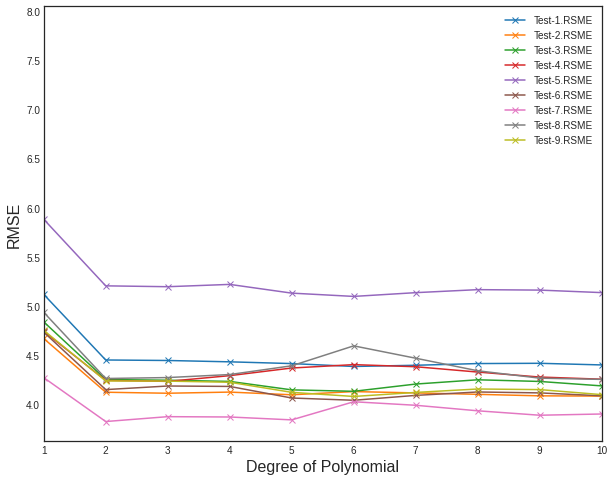

In [155]:
fig, ax = plt.subplots(figsize=(10, 8))
rmses = df_perf[["Test-{}.RSME".format(i) for i in range(1, 10)]]
idx = np.arange(1, rmses.shape[0]+1)
print(idx)
rmses = rmses.set_index(idx)
rmses.plot(ax=ax, marker='x')
_ = ax.set_xlabel('Degree of Polynomial', fontsize=16)
_ = ax.set_ylabel('RMSE', fontsize=16)
ax.set_xlim(1, 10)
#plt.legend(fontsize=16)

## Cross-Validation

### Validation Set Approach
Using Polynomial feature generation in scikit-learn<BR>
http://scikit-learn.org/dev/modules/preprocessing.html#generating-polynomial-features

In [171]:
# proportion of test set
t_prop = 0.5
# degree of the polynomial
p_order = np.arange(1,11)
# number of test
r_state = np.arange(0,10)

model_perf = defaultdict(dict)
df = pd.read_csv('https://www.palmetto.clemson.edu/dsci/datasets/isl/Auto.csv', na_values='?').dropna()

for run in r_state:
    X_train, X_test, y_train, y_test = train_test_split(df['horsepower'], df['mpg'], test_size=t_prop, random_state=run)
    for deg in p_order:
        model = make_pipeline(PolynomialFeatures(deg), LinearRegression())
        model.fit(X_train[:, np.newaxis], y_train)

        model_name = "{}".format(deg, run)
        y_test_pred = model.predict(X_test[:, np.newaxis])
        compute_model_perf(model_name, '{}'.format(run), y_test, y_test_pred)

In [175]:
df_perf = pd.DataFrame(model_perf).T
columns = ["{}.RSME".format(i) for i in r_state]
df_perf[columns]

,0.RSME,1.RSME,2.RSME,3.RSME,4.RSME,5.RSME,6.RSME,7.RSME,8.RSME,9.RSME
1,4.859693,4.980173,4.841760,4.555810,5.031241,5.439544,4.908849,5.046574,4.765767,5.265963
2,4.331631,4.341462,4.306994,4.116443,4.543571,4.913987,4.287797,4.473359,4.037528,4.551728
3,4.335544,4.336486,4.312218,4.119997,4.549848,4.909066,4.319872,4.467546,4.114500,4.549528
4,4.333420,4.325705,4.311931,4.110461,4.543790,4.919564,4.325577,4.479723,4.138631,4.588013
5,4.295236,4.280677,4.278791,4.091087,4.475733,4.846000,4.243132,4.463377,4.171523,4.634761
6,4.265151,4.270394,4.312903,4.103621,4.545616,4.819276,4.228213,4.524014,4.311254,4.897678
7,4.290108,4.277030,4.304132,4.148322,4.474109,4.851545,4.254062,4.489444,4.245088,5.047819
8,4.312006,4.291272,4.293450,4.166768,4.487742,4.875398,4.270978,4.467933,4.157876,4.715943
9,4.316085,4.297061,4.277299,4.147150,4.491972,4.875103,4.258049,4.441814,4.079239,4.598435
10,4.304513,4.286122,4.273481,4.111083,4.473552,4.856289,4.224443,4.428339,4.038241,6.637302


In [190]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

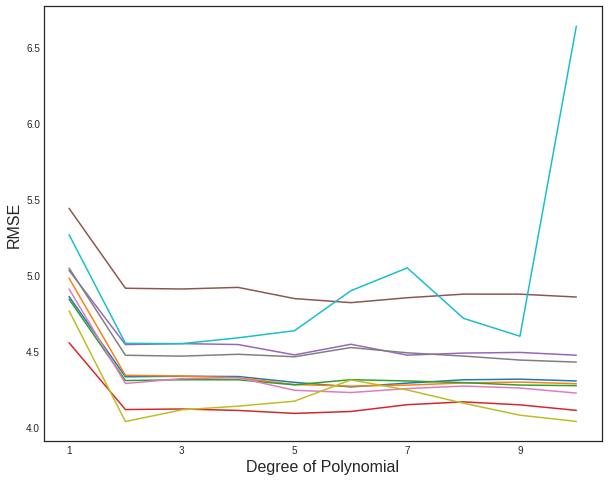

In [180]:
fig, ax = plt.subplots(figsize=(10, 8))
_ = df_perf[columns].plot(legend=False, ax=ax)
_ = ax.set_xlabel('Degree of Polynomial', fontsize=16)
_ = ax.set_ylabel('RMSE', fontsize=16)

### Leave On Out Cross Validation

In [199]:
from sklearn.model_selection import cross_val_score

# degree of the polynomial
p_order = np.arange(1,11)
# number of test
r_state = np.arange(0,10)

model_perf = {}
df = pd.read_csv('https://www.palmetto.clemson.edu/dsci/datasets/isl/Auto.csv', na_values='?').dropna()

X_train, y_train = df['horsepower'], df['mpg']
for deg in p_order:
    model = make_pipeline(PolynomialFeatures(deg), LinearRegression())
    model.fit(X_train[:, np.newaxis], y_train)
    score = cross_val_score(model, X_train[:, np.newaxis], y_train, cv=loo, scoring='neg_root_mean_squared_error').mean()*(-1)
    model_perf[deg] = score

(1.0, 10.0)

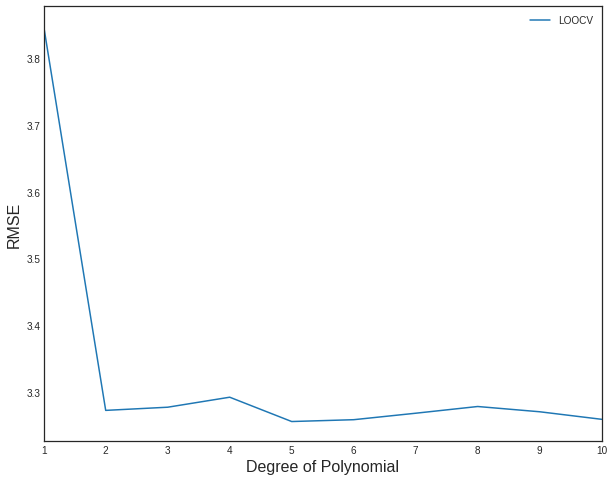

In [200]:
df_perf = pd.DataFrame({'LOOCV': model_perf})
fig, ax = plt.subplots(figsize=(10, 8))
df_perf.plot(ax=ax)
_ = ax.set_xlabel('Degree of Polynomial', fontsize=16)
_ = ax.set_ylabel('RMSE', fontsize=16)
ax.set_xlim(1, 10)

In [ ]:
### LOOCV

In [219]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

# degree of the polynomial
p_order = np.arange(1,11)
# number of test
r_state = np.arange(0,10)

model_perf = {}
df = pd.read_csv('https://www.palmetto.clemson.edu/dsci/datasets/isl/Auto.csv', na_values='?').dropna()

X_train, y_train = df['horsepower'], df['mpg']
loo = LeaveOneOut()
for deg in p_order:
    model = make_pipeline(PolynomialFeatures(deg), LinearRegression())
    
    scores = []
    for train, test in loo.split(X_train):
        X_train_loo, y_train_loo = X_train.iloc[train], y_train.iloc[train]
        model.fit(X_train_loo[:, np.newaxis], y_train_loo)
        
        X_test_loo, y_test_loo = X_train.iloc[test], y_train.iloc[test]
        y_pred_loo = model.predict(X_test_loo[:, np.newaxis])
        scores.append(mean_squared_error(y_test_loo, y_pred_loo, squared=False))
    model_perf[deg] = np.mean(scores)

(1.0, 10.0)

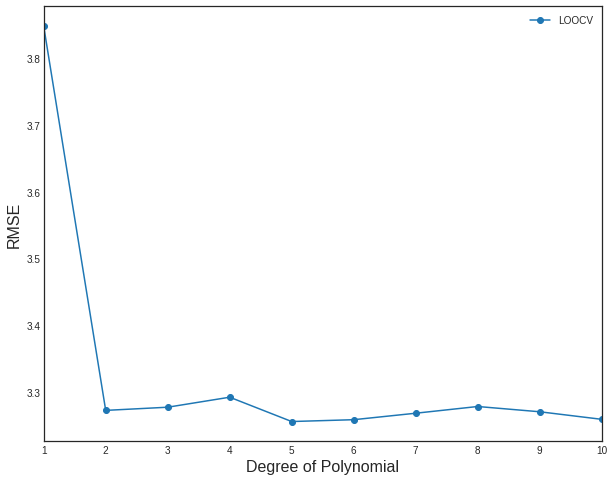

In [220]:
df_perf = pd.DataFrame({'LOOCV': model_perf})
fig, ax = plt.subplots(figsize=(10, 8))
df_perf.plot(marker='o', ax=ax)
_ = ax.set_xlabel('Degree of Polynomial', fontsize=16)
_ = ax.set_ylabel('RMSE', fontsize=16)
ax.set_xlim(1, 10)

### KFold Cross Validation

In [214]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# degree of the polynomial
p_order = np.arange(1,11)
# number of test
r_state = np.arange(0,10)

model_perf = {}
df = pd.read_csv('https://www.palmetto.clemson.edu/dsci/datasets/isl/Auto.csv', na_values='?').dropna()

X_train, y_train = df['horsepower'], df['mpg']
kfold = KFold(n_splits=10)
for deg in p_order:
    model = make_pipeline(PolynomialFeatures(deg), LinearRegression())
    
    scores = []
    for train, test in kfold.split(X_train):
        X_train_kfold, y_train_kfold = X_train.iloc[train], y_train.iloc[train]
        model.fit(X_train_kfold[:, np.newaxis], y_train_kfold)
        
        X_test_kfold, y_test_kfold = X_train.iloc[test], y_train.iloc[test]
        y_pred_kfold = model.predict(X_test_kfold[:, np.newaxis])
        scores.append(mean_squared_error(y_test_kfold, y_pred_kfold, squared=False))
    model_perf[deg] = np.mean(scores)

(1.0, 10.0)

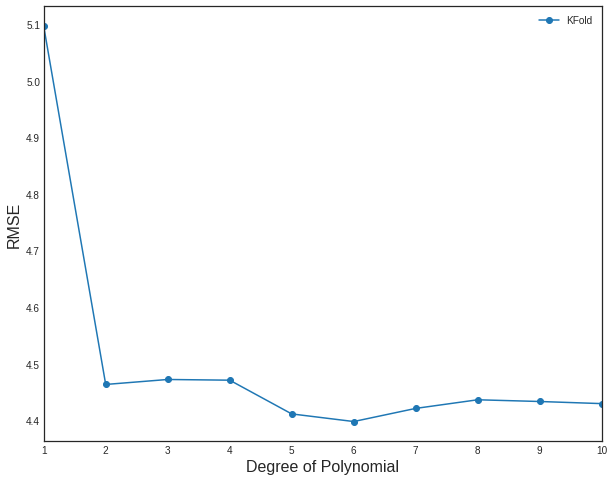

In [217]:
df_perf = pd.DataFrame({'KFold': model_perf})
fig, ax = plt.subplots(figsize=(10, 8))
df_perf.plot(marker='o', ax=ax)
_ = ax.set_xlabel('Degree of Polynomial', fontsize=16)
_ = ax.set_ylabel('RMSE', fontsize=16)
ax.set_xlim(1, 10)

In [221]:
from sklearn.model_selection import cross_val_score

# degree of the polynomial
p_order = np.arange(1,11)
# number of test
r_state = np.arange(0,10)
# number of folds
folds = 10

model_perf = {}
df = pd.read_csv('https://www.palmetto.clemson.edu/dsci/datasets/isl/Auto.csv', na_values='?').dropna()

X_train, y_train = df['horsepower'], df['mpg']
kfold_10 = KFold(n_splits=folds)
for deg in p_order:
    model = make_pipeline(PolynomialFeatures(deg), LinearRegression())
    model.fit(X_train[:, np.newaxis], y_train)
    score = cross_val_score(model, X_train[:, np.newaxis], y_train, cv=kfold_10, 
                            scoring='neg_root_mean_squared_error').mean()*(-1)
    model_perf[deg] = score

(1.0, 10.0)

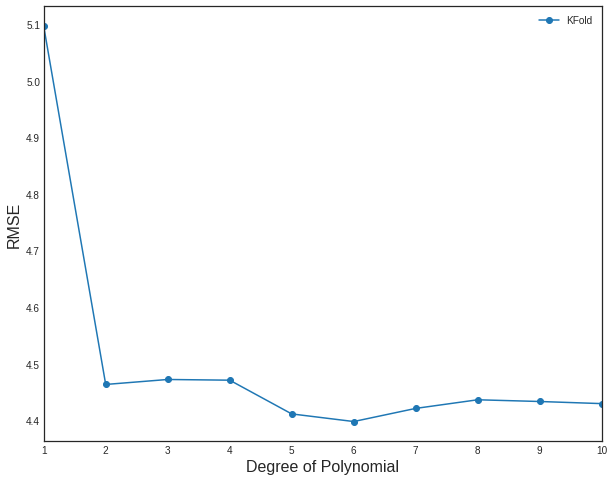

In [222]:
df_perf = pd.DataFrame({'KFold': model_perf})
fig, ax = plt.subplots(figsize=(10, 8))
df_perf.plot(marker='o', ax=ax)
_ = ax.set_xlabel('Degree of Polynomial', fontsize=16)
_ = ax.set_ylabel('RMSE', fontsize=16)
ax.set_xlim(1, 10)

## Bootstrap

In [ ]:
### A single estimate from the original data

In [244]:
df = pd.read_csv('https://www.palmetto.clemson.edu/dsci/datasets/isl/Auto.csv', na_values='?').dropna()

X_train, y_train = df['horsepower'], df['mpg']
model_params = []
poly = PolynomialFeatures(6)
X_poly = poly.fit_transform(X_train[:, np.newaxis])
reg = LinearRegression(fit_intercept=True)
reg.fit(X_poly, y_train)
p = {"beta_{}".format(i): v for i, v in enumerate(reg.coef_)}
p['beta_0'] = reg.intercept_
p

{'beta_0': -162.33494378744146,
 'beta_1': 11.241314232468916,
 'beta_2': -0.24363898564168954,
 'beta_3': 0.002579932843318597,
 'beta_4': -1.4528164060448231e-05,
 'beta_5': 4.172166687826939e-08,
 'beta_6': -4.802380715318577e-11}

In [245]:
def estimator(X, y):
    model_params = []
    poly = PolynomialFeatures(6)
    X_poly = poly.fit_transform(X)
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X_poly, y_train)
    p = {"beta_{}".format(i): v for i, v in enumerate(reg.coef_)}
    p['beta_0'] = reg.intercept_
    return p

In [247]:
X_train, y_train = df['horsepower'][:, np.newaxis], df['mpg']
estimator(X_train, y_train)

{'beta_0': -162.33494378744146,
 'beta_1': 11.241314232468916,
 'beta_2': -0.24363898564168954,
 'beta_3': 0.002579932843318597,
 'beta_4': -1.4528164060448231e-05,
 'beta_5': 4.172166687826939e-08,
 'beta_6': -4.802380715318577e-11}

In [250]:
# help(df.sample)

Help on method sample in module pandas.core.generic:

sample(n=None, frac=None, replace=False, weights=None, random_state=None, axis=None) -> ~FrameOrSeries method of pandas.core.frame.DataFrame instance
    Return a random sample of items from an axis of object.
    
    You can use `random_state` for reproducibility.
    
    Parameters
    ----------
    n : int, optional
        Number of items from axis to return. Cannot be used with `frac`.
        Default = 1 if `frac` = None.
    frac : float, optional
        Fraction of axis items to return. Cannot be used with `n`.
    replace : bool, default False
        Allow or disallow sampling of the same row more than once.
    weights : str or ndarray-like, optional
        Default 'None' results in equal probability weighting.
        If passed a Series, will align with target object on index. Index
        values in weights not found in sampled object will be ignored and
        index values in sampled object not in weights will be

In [251]:
df.sample(frac=1.0, replace=True, random_state=6300)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
7,14.0,8,440.0,215.0,4312,8.5,70,1,plymouth fury iii
359,28.1,4,141.0,80.0,3230,20.4,81,2,peugeot 505s turbo diesel
364,26.6,8,350.0,105.0,3725,19.0,81,1,oldsmobile cutlass ls
91,13.0,8,400.0,150.0,4464,12.0,73,1,chevrolet caprice classic
173,24.0,4,119.0,97.0,2545,17.0,75,3,datsun 710
...,...,...,...,...,...,...,...,...,...
335,35.0,4,122.0,88.0,2500,15.1,80,2,triumph tr7 coupe
376,31.0,4,91.0,68.0,1970,17.6,82,3,mazda glc custom
46,22.0,4,140.0,72.0,2408,19.0,71,1,chevrolet vega (sw)
62,13.0,8,350.0,165.0,4274,12.0,72,1,chevrolet impala


In [264]:
def bootstrap(input_df, estimator, n_bootstraps):
    params = []
    for i in range(n_bootstraps):
        df1 = input_df.sample(frac=1.0, replace=True, random_state=i)
        X_train, y_train = df1['horsepower'][:, np.newaxis], df1['mpg']
        param = estimator(X_train, y_train)
        params.append(param)
    return pd.DataFrame(params)

In [265]:
params = bootstrap(df, estimator, 100)

In [266]:
params.describe().loc[['mean', 'std'], :]

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6
mean,12.253235,0.744859,-0.019055,0.000241,-0.000002,5.369985e-09,-7.094569e-12
std,139.492329,7.982268,0.180733,0.002073,0.000013,3.991243e-08,5.000011e-11


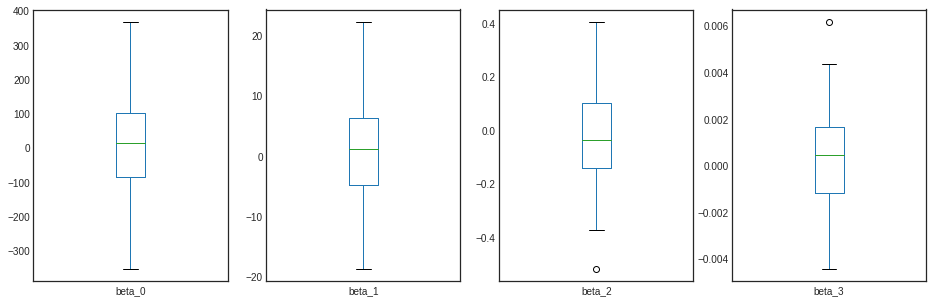

In [287]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
for i in range(4):
    _ = params[['beta_{}'.format(i)]].plot.box(ax=ax[i])